### Multiple regression using an APT-style model

The following example will show how **we can extend the linear regression model** introduced in
previous sections to estimate multiple regressions in Python. In the spirit of **arbitrage pricing theory
(APT)**, we will examine regressions that seek to determine whether the monthly returns on **Microsoft
stock** can be explained by reference to unexpected changes in a set of macroeconomic and financial
variables. 

For this we rely on the dataset 'macro.xls' which contains 13 data series of financial and
economic variables as well as a date variable spanning the time period from March 1986 until March
2018 (i.e., 385 monthly observations for each of the series). In particular, the set of financial and
economic variables comprises the **Microsoft stock price, the S&P500 index value, the consumer price
index, an industrial production index, Treasury bill yields** for the following maturities: three months,
six months, one year, three years, five years and ten years, a measure of ’narrow’ **money supply, a
consumer credit series, and a ’credit spread’ series**. The latter is defined as the difference in annualised average yields between a portfolio of bonds rated AAA and a portfolio of bonds rated BAA.
Before we can start with our analysis, we need to import several libraries and the dataset
'macro.xls' into Python. The index column of the imported DataFrame is set by the argument index_col=0.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

In [2]:
data = pd.read_excel('macro.xls', index_col=0)
data.head()


,MICROSOFT,SANDP,CPI,INDPRO,M1SUPPLY,CCREDIT,BMINUSA,USTB3M,USTB10Y
Date,,,,,,,,,
1986-03-01,0.095486,238.899994,108.8,56.5414,624.3,606.7990,1.50,6.76,7.78
1986-04-01,0.111979,235.520004,108.6,56.5654,647.0,614.3669,1.40,6.24,7.30
1986-05-01,0.121528,247.350006,108.9,56.6850,645.7,621.9152,1.20,6.33,7.71
1986-06-01,0.106771,250.839996,109.5,56.4959,662.8,627.8910,1.21,6.40,7.80
1986-07-01,0.098958,236.119995,109.5,56.8096,673.4,633.6083,1.28,6.00,7.30


Now that we have prepared the dataset we can start with the actual analysis. The first stage is **to
generate a set of changes or differences for each of the variables**, since APT posits that the stock
returns can be explained by reference to the unexpected changes in the macroeconomic variables
rather than their levels. The unexpected value of a variable can be defined as **the difference between
the actual (realised) value of the variable and its expected value**. The question then arises about how we believe that investors might have formed their expectations, and while there are many ways to
construct measures of expectations, **the easiest is to assume that investors have naive expectations
that the next period value of the variable is equal to the current value**. This being the case, the entire change in the variable from one period to the next is the unexpected change (because investors are assumed to expect no change)

To transform the variables, we re-construct the DataFrame where each variable is defined and
computed as follows: To compute changes or differences, we set up a user-defined function to facilitate the calculation as used in previous sections

In [3]:
def LogDiff(x):
    x_diff = 100*np.log(x/x.shift(1))
    x_diff = x_diff.dropna()
    return x_diff


In [4]:
data = pd.DataFrame({'dspread' : data['BMINUSA'] - \
data['BMINUSA'].shift(1),
'dcredit' : data['CCREDIT'] - \
data['CCREDIT'].shift(1),
'dprod' : data['INDPRO'] - \
data['INDPRO'].shift(1),
'rmsoft' : LogDiff(data['MICROSOFT']),
'rsandp' : LogDiff(data['SANDP']),
'dmoney' : data['M1SUPPLY'] - \
data['M1SUPPLY'].shift(1),
'inflation' : LogDiff(data['CPI']),
'term' : data['USTB10Y'] - data['USTB3M'],
'dinflation' : LogDiff(data['CPI']) - \
LogDiff(data['CPI']).shift(1),
'mustb3m' : data['USTB3M']/12,
'rterm' : (data['USTB10Y'] - data['USTB3M']) - \
(data['USTB10Y'] - data['USTB3M']).shift(1),
'ermsoft' : LogDiff(data['MICROSOFT']) - \
data['USTB3M']/12,
'ersandp' : LogDiff(data['SANDP']) - \
data['USTB3M']/12})

In [5]:
data.head()

,dspread,dcredit,dprod,rmsoft,rsandp,dmoney,inflation,term,dinflation,mustb3m,rterm,ermsoft,ersandp
Date,,,,,,,,,,,,,
1986-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.02,NaN,0.563333,NaN,NaN,NaN
1986-04-01,-0.10,7.5679,0.0240,15.933171,-1.424918,22.7,-0.183993,1.06,NaN,0.520000,0.04,15.413171,-1.944918
1986-05-01,-0.20,7.5483,0.1196,8.183334,4.900851,-1.3,0.275862,1.38,0.459855,0.527500,0.32,7.655834,4.373351
1986-06-01,0.01,5.9758,-0.1891,-12.945833,1.401091,17.1,0.549452,1.40,0.273590,0.533333,0.02,-13.479167,0.867757
1986-07-01,0.07,5.7173,0.3137,-7.599084,-6.047514,10.6,0.000000,1.30,-0.549452,0.500000,-0.10,-8.099084,-6.547514


We save the data for for future research since the calculation of these series is handy. Recall that although there are several ways of keeping data file, we employ the pickle library and save all columns

In [6]:
import pickle


In [7]:
with open('macro.pickle', 'wb') as handle:
    pickle.dump(data, handle)


We can now run the regression. To create a regression specification, we first write the formula statement ’ermsoft ∼ ersandp + dprod + dcredit + dinflation + dmoney + dspread + rterm’. The formula
string will automatically add a constant term, unless the user types ’-1’ at the end of the formula.
Next, the regression function ols is called from statsmodels.formula.api, written in shorthand as
smf, with both the formula and data input. The function fit following it allows for different treatments of the regression standard errors. Here we leave it as the default setting. Finally, typing the command print(results.summary()) obtains all the information from the regression.

In [8]:
formula = 'ermsoft ~ ersandp + dprod + dcredit + dinflation + dmoney + dspread + rterm'

In [9]:
results = smf.ols(formula, data).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                ermsoft   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     28.24
Date:                Fri, 30 Jul 2021   Prob (F-statistic):           3.52e-31
Time:                        08:25:46   Log-Likelihood:                -1328.3
No. Observations:                 383   AIC:                             2673.
Df Residuals:                     375   BIC:                             2704.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3260      0.475      2.789      0.0

### What should we focus on in the regression table? 
Although the output table above contains a lot of information, we only need to focus on a small number of quantities.
These are the coefficients (the estimates of $\beta_0$ and $\beta_1$), as well as their $p$- and $R$-squared values.

### $p$-values
The null hypothesis we are testing here is 
$$ H_0:  \beta_1 = 0 $$ 
and the alternative is
$$ H_a: \beta_1 \neq 0.$$
The [p-value](https://towardsdatascience.com/p-values-explained-by-data-scientist-f40a746cfc8) of $\beta_1$ (given under the column: $"P>|t|"$) is XXXX.  Thus, it is statistically significant at the XXXX level, and we XXXX the null hypothesis. This implies that .....

Let us take a few minutes to examine the main regression results. Which of the variables has a
statistically significant impact on the Microsoft excess returns? Readers can use their knowledge of
the effects of the financial and macroeconomic environment on stock returns **to examine whether the
coefficients have their expected signs and whether the sizes of the parameters are plausible**.
The regression **F-statistic takes a value of 28.24 (third row, top right corner)**. Remember that
this tests the null hypothesis of all the slope parameters being jointly zero. The p-value of zero
attached to the test statistic shows that this null hypothesis should be rejected. However, a number
of parameter estimates are not significantly different from zero -- specifically, those on the ’dprod’,
’dcredit’, ’dmoney’ and ’dspread’ variables.

In [10]:
hypotheses = 'dprod = dcredit = dmoney = dspread = 0'
f_test = results.f_test(hypotheses)
print(f_test)

<F test: F=array([[0.41387856]]), p=0.7986453783414765, df_denom=375, df_num=4>


Let us test the **null hypothesis that the parameters on these four variables are jointly zero using an
F-test**. To achieve this, we write the hypotheses using the string literals 'dprod = dcredit = dmoney
= dspread = 0'. Applying the function f_test from the instance result and
typing the command f_test = results.f_test(hypotheses).
As shown, the resulting F-test statistic value is 0.414 with p-value 0.799; there are four restrictions and 375 usable observations. This
suggests that the null hypothesis cannot be rejected.

## $R$-squared

One of the key quantities that should be paid attention to while interpreting a regression table is the quantity
[$R$-squared](https://blog.minitab.com/blog/adventures-in-statistics-2/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit). Note that the table shows $R$-squared and adjusted $R$-squared. We will focus on $R$-squared. This quantity is always going to be between 0 and 1. For the pay vs. age model, this quantity is 0.345 = 34.5%. 

An $R$-squared of 34.5% in this linear model means that **this observed variation in ermsoft is not due to random chance**; rather, the factors analyzed systematically explains 34.5% of this variation in  ermsoft. The higher the $R$-squared, the higher the percentage of observed variation that can be explained by the model. 

### Geometric interpretation of $R$-Squared
The formula for $R$-squared is the following:
  $$ R^2 = 1 - \frac{\mathrm{RSS}}{\mathrm{TSS}} $$
Here [RSS](https://gerardnico.com/data_mining/rss) and [TSS](https://gerardnico.com/data_mining/tss) denote the Residual and Total Sum of Squares respectively. To understand the above
formula carefully, let us plot pay vs. age again. 

In [21]:
## Write code to find residuals from fitted values
res = data['ermsoft'] - results.fittedvalues
res = res.dropna()
res[0:5]

Date
1986-05-01    -1.124588
1986-06-01   -16.422526
1986-07-01     0.794840
1986-08-01   -11.473687
1986-09-01     6.478145
dtype: float64

In [22]:
results.resid[0:5]

Date
1986-05-01    -1.124588
1986-06-01   -16.422526
1986-07-01     0.794840
1986-08-01   -11.473687
1986-09-01     6.478145
dtype: float64

In [43]:
# The mean for pay 
mean_ermsoft = data['ermsoft'].mean()

dev = (data['ermsoft'] - mean_ermsoft)

dev = dev.dropna()

## The total sum of squares:
TSS = sum(dev*dev)

## Residual sum of squares
RSS = sum(res*res)

In [45]:
RSS

23078.10860011572

In [46]:
R_squared = (TSS - RSS)/TSS
R_squared

0.34878444669506875

### Diagnostic testing

#### Testing for heteroscedasticity

This time, we are less interested in the coefficient estimates reported in the regression summary table,
but we focus on the properties of the residuals from this regression. **To get a first impression of the
characteristics of the residuals, we want to plot them**. To obtain the residuals, we use the command
**results.resid**, which allows us to access the residuals of regression specification from the instance
results. To plot this series, we then create a figure and plot the series by the plot. The X and Y axes
are further options to be set up depending on what the user requires. 


Let us examine the patterns in the residuals over time. **If the residuals of the
regression have a systematically changing variability over the sample, that is a sign of heteroscedasticity**. In this case, it is hard to see any clear pattern (although it is interesting to note the considerable
reduction in volatility post-2003), so we need to run a formal statistical test

In [15]:
import pickle
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
from statsmodels.compat import lzip

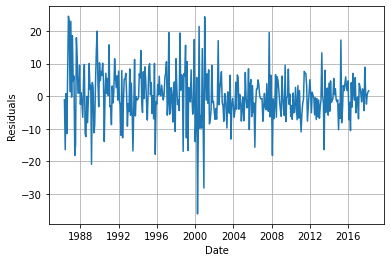

In [13]:
plt.figure(1)
plt.plot(results.resid)
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

To do so, we select the function **het_breuschpagan** from the Statsmodel library. **The aim of this function is to test the hypothesis that the residual variance does not depend on functions (higher order
powers or multiplicative combinations) of the explanatory variables**, thus requiring two essential
inputs: 'residuals' and 'exogenous variables'.

There are four outputs in total produced by this function: a Lagrange multiplier statistic, p-value,
F-test statistic value and F-test p-value. Note that the het_breuschpagan tests the hypothesis in two
ways. The first method is to employ the generic formula for an LM test using $n*R^2$
(the number
of observations times the auxiliary regression), while the F-statistic is preferable when samples are
small or moderately large since otherwise the test exaggerates the statistical significance. To better
present the two test results, we finally create a list with four names and link them to each statistic.

As you can see from the test statistics and p-values, both tests lead to the conclusion that there
does not seem to be a serious problem of heteroscedastic errors for our APT-style model with the
p-values both being 0.87, respectively.

In [16]:
# breusch-pagan heteroskedasticity test
name = ['Lagrange multiplier statistic', 'p-value',
'f-value', 'f p-value']
test = sms.het_breuschpagan(results.resid, results.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 3.16066015042023),
 ('p-value', 0.8697526743786463),
 ('f-value', 0.445770255271215),
 ('f p-value', 0.8729003404188317)]

We can specify **to estimate the regression with heteroscedasticity-robust standard errors in Python**.
When we create the regression specification by the command smf.ols(formula, data), we usually
follow the function fit to produce the result instance. So far, we have only focused on the regression
model itself that specifies the dependent and independent variables. If we move to usage of the fit
function, we are presented with different options for adjusting the standard errors.

In order to obtain **standard errors that are robust to heteroscedasticity**, we select the argument
cov_type=’HC1’. Obviously, there are a number of options you can select. For more information
on the different standard error adjustments, refer to the Statsmodel documentation. Comparing
the regression output for our APT-style model using robust standard errors with that using ordinary
standard errors, we find that the changes in significance are only marginal, as shown in the output
below

In [17]:
results = smf.ols(formula, data).fit(cov_type='HC1')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                ermsoft   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     29.89
Date:                Fri, 30 Jul 2021   Prob (F-statistic):           9.27e-33
Time:                        09:22:46   Log-Likelihood:                -1328.3
No. Observations:                 383   AIC:                             2673.
Df Residuals:                     375   BIC:                             2704.
Df Model:                           7                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3260      0.459      2.888      0.0

**Of course, only the standard errors have changed and the parameter estimates remain identical to
those estimated before**. The heteroscedasticity-consistent **standard errors are smaller for most variables, resulting in t-ratios growing in absolute value and p-values being smaller**. The main changes in
the conclusions reached are that the difference in the consumer credit variable ('dcredit'), which was
previously significant only at the 10% level, is now significant at 5%, and the unexpected inflation
and change in industrial production variables are now significant at the 10% level.

#### Autocorrelation and dynamic models

In this section, we want to apply different tests for autocorrelation in Python using the APT-style model. The simplest test for autocorrelation is due to **Durbin and Watson (1951)**. **It is a test for first-order
autocorrelation** - i.e., **it tests only for a relationship between an error and its immediately previous
value**. To access the Durbin-Watson test, we access the function durbin_watson via the module
statsmodels.stats.api and generate a new variable residuals by the command results.resid.



In [19]:
residuals = results.resid

In [20]:
sms.durbin_watson(residuals)

2.0973940504299913

The value of the DW statistic is 2.097. What is the appropriate conclusion regarding the presence or
otherwise of first order autocorrelation in this case?

We must not reject the null hypothesis because there is little evidence of
autocorrelation

An alternative test for autocorrelation is the **Breusch-Godfrey test**. It is more general than DW
and allows us to test for higher order autocorrelation. In Python, the Breusch-Godfrey test can be
conducted by the same module statsmodels.stats.api. There are two inputs for this test: **we need to
feed the function with the results instance created by the OLS specification beforehand and employ
10 lags in the test**. However, unlike the Durbin-Watson test, which only produces one statistic, there
are four outputs for the Breusch-Godfrey test. This is because the hypothesis is tested in two different ways. Consistent with the example above, we create a list with the name of the output in order to better present the results. The final results shall appear as below.

In [21]:
name = ['Lagrange multiplier statistic', 'p-value',
'f-value', 'f p-value']
results1 = sms.acorr_breusch_godfrey(results, 10)
lzip(name, results1)

[('Lagrange multiplier statistic', 4.766591436782221),
 ('p-value', 0.9062145800242334),
 ('f-value', 0.45998207324796764),
 ('f p-value', 0.915017998157289)]

Therefore, we can not reject the null hypothesis

### Testing for non-normality

One of the most commonly applied tests for normality is the Bera-Jarque (BJ) test. Assume that we
would like to test whether the normality assumption is satisfied for the residuals of the APT-style
regression of Microsoft stock on the unexpected changes in the financial and economic factors, i.e.
the ’residuals’ variable that we created.

Before calculating the actual test statistic, it might be useful to have a look at the data as this might
give us a first idea of whether the residuals might be normally distributed. If the residuals follow a
normal distribution we expect a histogram of the residuals to be bell-shaped (with no outliers). To
create a histogram of the residuals, we first generate an OLS regression outcome instance with the
variable named results and access the residual series by the command results.resid. We next are going to plot the 'residuals'. Specifically, we first create a figure object by the module matplotlib.pyplot.
Plotting the series by the function hist and setting up additional parameters such as the number of
bins, edgecolour, linewidth, x and y axis and so on.

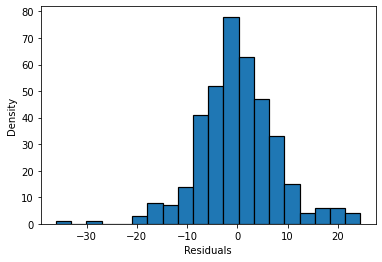

In [22]:
plt.figure(1)
plt.hist(residuals,20,edgecolor='black',linewidth=1.2)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

Looking at the histogram plot, we see that the distribution of the residuals roughly resembles a bell-shape although we also find that there are some large negative outliers which might
lead to a considerable negative skewness. We could increase the number of bins or lower the width
of the bins in order to obtain a more differentiated histogram.

However, if we want to test the normality assumption of the residuals more formally, it is best to
turn to a normality test. The standard test for the normality of a data series in Python is the BJ test.
To do so, we feed the variable 'residuals' into the function jarque_bera and zip the output’s names
with outcomes. The result appear in the output window below.

In [23]:
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(residuals)
lzip(name, test)

[('Jarque-Bera', 63.505472671589565),
 ('Chi^2 two-tail prob.', 1.6216675409917293e-14),
 ('Skew', -0.00561267747998391),
 ('Kurtosis', 4.994825605906648)]

Python reports the BJ statistic and χ
2
two-tailed p-value for the **test that the residuals are overall
normally distributed**, i.e., that both the kurtosis and the skewness are those of a normal distribution.
What could cause this strong deviation from normality? Having another look at the histogram,
it appears to have been caused by a small number of very large negative residuals representing
monthly stock price falls of more than –25%. What does the non-normality of residuals imply for the
inferences we make about coefficient estimates? Generally speaking, **it could mean that these inferences could be wrong**, although the sample is probably large enough that we need be less concerned
than we would with a smaller sample.

### Dummy variable construction and use

As we saw from the plot of the distribution above, **the non-normality in the residuals from the Microsoft regression appears to have been caused by a small number of outliers in the sample**. Such
events can be identified if they are present by plotting the actual values and the residuals of the
regression. We have already generated a data series containing the residuals of the Microsoft regression. Let us now create a series of the fitted values. For this, we use the function fittedvalues from the
results instance. We name the variable y_fitted and define that it will contain the linear prediction
for the Microsoft regression. 

In [24]:
y_fitted = results.fittedvalues

In order to plot both the residuals and fitted values in one times-series graph, we import the matplotlib.pyplot module. As usual, we create a figure object and plot two separate series in two commands. To be able to clearly illustrate each series in the chart, we add the label argument to represent
each data series. Then we set up the x and y axis, grid, legend and so on. Finally, type the command
plt.show() 

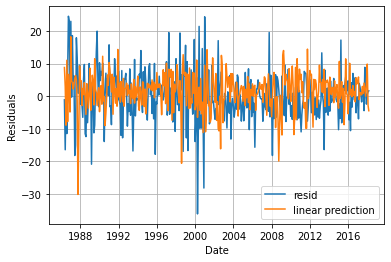

In [25]:
plt.figure(1)
plt.plot(residuals, label='resid')
plt.plot(y_fitted, label='linear prediction')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True)
plt.legend()
plt.show()

From the graph, **it can be seen that there are several large (negative) outliers**, but the largest all occur
in 2000. These large outliers correspond to months where the actual return was much smaller (i.e.,
more negative) than the model would have predicted, resulting in a large residual. Interestingly, **the
residual in October 1987** is not quite so prominent because even though the stock price fell considerably, the market index value fell as well, so that the stock price fall was at least in part predicted.
In order to identify the exact dates when the biggest outliers were realised, it is probably easiest
to just examine a table of values for the residuals. This can be done by applying the Pandas built-in
function nsmallest and specifying the number of smallest values to pick up. Hitting SHIFT and
ENTER leads Python to output the two smallest values from the given series.

In [26]:
residuals.nsmallest(2)

Date
2000-04-01   -36.075347
2000-12-01   -28.143156
dtype: float64

It is evident that the two most extreme residuals were in April (–36.075) and December 2000 (–28.143). One way of removing the (distorting) effect of big outliers in the data is by using dummy variables. It would be tempting, but incorrect, to construct one dummy variable that takes the value 1 for both
April and December 2000. This would not have the desired effect of setting both residuals to zero.
Instead, to remove two outliers requires us to construct two separate dummy variables. In order to
create the April 2000 dummy first, we generate a series called 'APR00DUM' into data DataFrame. To
precisely assign the value 1 on the date of April 2000 while keeping the rest of the series as zeros, we employ the built-in function where from the NumPy module; there are three parameters are required
as inputs: condition, x, and y, respectively. The first argument would be the condition, since the aim
of this function is to return elements, either from the series x or y, depending on the condition. In
other words, the function will yield the value of x when the condition is true, otherwise it will yield
y. 

In this setting, we set up the argument data.index == '2000-4-1' since the returned elements would
take the value 1 only when the index value of the data DataFrame is April 2000.
We repeat the process above to create another dummy variable called 'DEC00DUM' that takes
the value 1 in December 2000 and zero elsewhere.

Let us now rerun the regression to see whether the results change once we have removed the
effect of the two largest outliers. For this, we just add the two dummy variables APR00DUM and
DEC00DUM to the list of independent variables written in the formula statement. Repeating the
regression specification commands, the output of this regression should look as follows.

In [27]:
data['APR00DUM'] = np.where(data.index == '2000-4-1', 1, 0)
data['DEC00DUM'] = np.where(data.index == '2000-12-1', 1, 0)


In [28]:
# regression
formula = 'ermsoft ~ ersandp + dprod + dcredit + \
dinflation + dmoney + dspread + rterm + \
APR00DUM + DEC00DUM'
results = smf.ols(formula, data).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                ermsoft   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     28.33
Date:                Fri, 30 Jul 2021   Prob (F-statistic):           2.22e-37
Time:                        11:35:12   Log-Likelihood:                -1309.7
No. Observations:                 383   AIC:                             2639.
Df Residuals:                     373   BIC:                             2679.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4198      0.454      3.125      0.0

Note that the dummy variable parameters are both highly significant and take approximately the
values that the corresponding residuals would have taken if the dummy variables had not been
included in the model. By comparing the results with those of the regression above that excluded
the dummy variables, it can be seen that the coefficient estimates on the remaining variables change
quite a bit in this instance and the significances improve considerably. The R
2 value has risen from 0.34 to 0.41 because of the perfect fit of the dummy
variables to those two extreme outlying observations.

 ### Multicollinearity

Let us assume that we would like to test for multicollinearity in the Microsoft regression
('macro.pickle' workfile). To generate a correlation matrix in Python, we apply the Pandas built-in function corr followed by the DataFrame data. In the command for indexing Pandas columns, we
enter the list of regressors (not including the regressand or the S&P500 returns).

In [30]:
data = data[['dprod','dcredit','dinflation','dmoney','dspread','rterm']]

In [31]:
data.corr()

,dprod,dcredit,dinflation,dmoney,dspread,rterm
dprod,1.000000,0.094295,-0.143551,-0.052768,-0.052216,-0.043832
dcredit,0.094295,1.000000,-0.024604,0.150026,0.062877,-0.004053
dinflation,-0.143551,-0.024604,1.000000,-0.093571,-0.227100,0.041606
dmoney,-0.052768,0.150026,-0.093571,1.000000,0.169047,0.004045
dspread,-0.052216,0.062877,-0.227100,0.169047,1.000000,-0.018023
rterm,-0.043832,-0.004053,0.041606,0.004045,-0.018023,1.000000


Do the results indicate any significant correlations between the independent variables? In this particular case, the largest observed correlations (in absolute value) are 0.17 between the money supply
and spread variables, and −0.23 between the spread and unexpected inflation. Both are probably
sufficiently small in absolute value that they can reasonably be ignored.

### The RESET test for functional form

To conduct the RESET test for our Microsoft regression, we need to import the reset_ramsay function
from the statsmodels.stats.outliers_influence module. This function requires the regression results.

In [33]:
from statsmodels.stats.outliers_influence import reset_ramsey

In [40]:
with open('macro.pickle', 'rb') as handle:
    data = pickle.load(handle)


In [41]:
data = data.dropna() 

In [42]:
#formula = 'ermsoft ~ ersandp + dprod + dcredit + dinflation + dmoney + dspread + rterm'
results = smf.ols(formula, data).fit()

In [43]:
reset_ramsey(results,degree=4)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[0.9937673]]), p=0.3957441239174355, df_denom=372, df_num=3>

Take some time to examine the result statistics. Based on the
F-statistic having four degrees of freedom, we can assume that **Python included three higher order
terms of the fitted values in the auxiliary regression**. With an F-value of 0.9937 and a corresponding
p-value of 0.3957, the RESET test results imply that we cannot reject the null hypothesis that the
model has no omitted variables. In other words, we do not find strong evidence that the chosen
linear functional form of the model is incorrect.